# 1. K-MEANS를 이용한 붓꽃 데이터 셋 군집화

In [6]:
from sklearn.preprocessing import scale
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [3]:
iris = load_iris()
iris_df = pd.DataFrame(data= iris.data, columns = ['sepal_length','sepal_width','petal_length','petal_width'])
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [4]:
KM = KMeans(n_clusters=3, init= 'k-means++', max_iter = 300, random_state= 0)
KM.fit(iris_df)

KMeans(n_clusters=3, random_state=0)

In [5]:
#군집화된 레이블 
KM.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0], dtype=int32)

In [9]:
#target과 cluster 비교
iris_df['target'] = iris.target
iris_df['cluster'] = KM.labels_
iris_result = iris_df.groupby(['target', 'cluster'])['sepal_length'].count()
iris_result

target  cluster
0       1          50
1       0          48
        2           2
2       0          14
        2          36
Name: sepal_length, dtype: int64

In [12]:
#차원을 줄여 군집화 
#KMeans에서 차원 축소하면 정확도가 올라감 
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(iris.data)

#주성분1, 주성분2
iris_df['pca_x'] = pca_transformed[:,0]
iris_df['pca_y'] = pca_transformed[:,1]
iris_df.head(2)


,sepal_length,sepal_width,petal_length,petal_width,target,cluster,pca_x,pca_y
0,5.1,3.5,1.4,0.2,0,1,-2.684126,0.319397
1,4.9,3.0,1.4,0.2,0,1,-2.714142,-0.177001


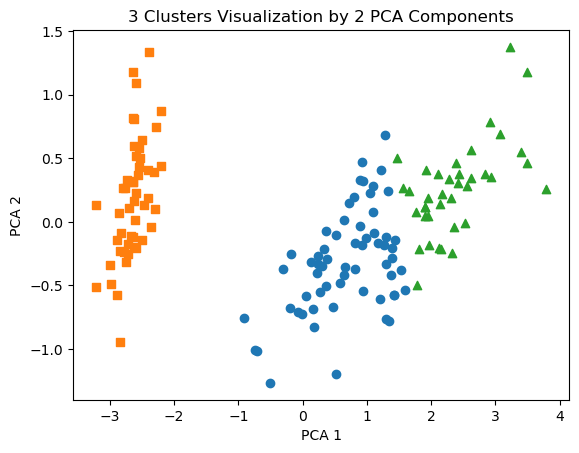

In [15]:
#cluster 산점도로 시각화
plt.scatter(x = iris_df.loc[iris_df['cluster']==0, 'pca_x'], y = iris_df.loc[iris_df['cluster']==0, 'pca_y'], marker = 'o')
plt.scatter(x = iris_df.loc[iris_df['cluster']==1, 'pca_x'], y = iris_df.loc[iris_df['cluster']==1, 'pca_y'], marker = 's')
plt.scatter(x = iris_df.loc[iris_df['cluster']==2, 'pca_x'], y = iris_df.loc[iris_df['cluster']==2, 'pca_y'], marker = '^')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('3 Clusters Visualization by 2 PCA Components')
plt.show()

In [45]:
# silhouette 계수 측정 
from sklearn.metrics import silhouette_samples, silhouette_score

#iris의 모든 개별 데이터에 실루엣 계수 값을 구함 
score_samples = silhouette_samples(iris.data, iris_df['cluster'])
iris_df['silhouette_coeff'] = score_samples

#모든 데이터의 평균 실루엣 계수
print('붓꽃 데이터 셋 실루엣 점수', silhouette_score(iris.data, iris_df['cluster']))

붓꽃 데이터 셋 실루엣 점수 0.5528190123564095


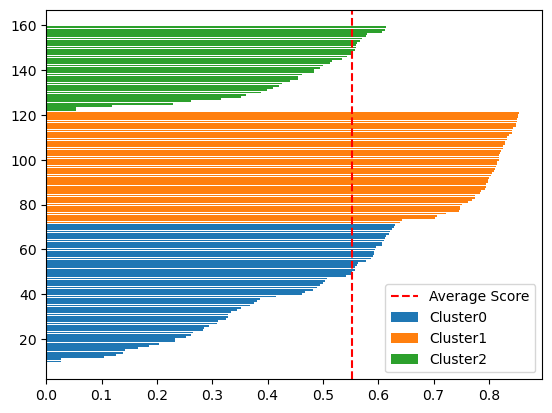

In [51]:
y_lower = 10
for i in range(3):
    cluster_i = score_samples[iris_df['cluster']==i]
    cluster_i.sort()
    y_upper = y_lower + len(cluster_i)
    plt.barh(range(y_lower,y_upper), cluster_i, edgecolor ='none', label=f'Cluster{i}')
    y_lower = y_upper
    
    avg_score = silhouette_score(iris.data, iris_df['cluster'])
plt.axvline(avg_score, color = 'red', linestyle='--', label = 'Average Score')
plt.legend()
plt.show()
    

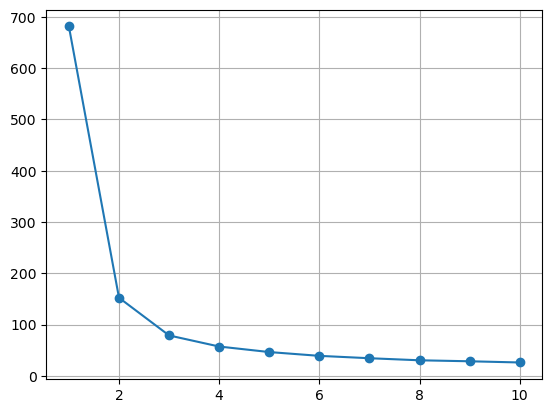

In [54]:
# scree plot
inertia = []
scree_df = iris_df[['sepal_length','sepal_width','petal_length','petal_width']]
k_values = range(1,11)
for k in  k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scree_df)
    inertia.append(kmeans.inertia_)

plt.plot(k_values, inertia, marker='o')
plt.grid()
plt.show()


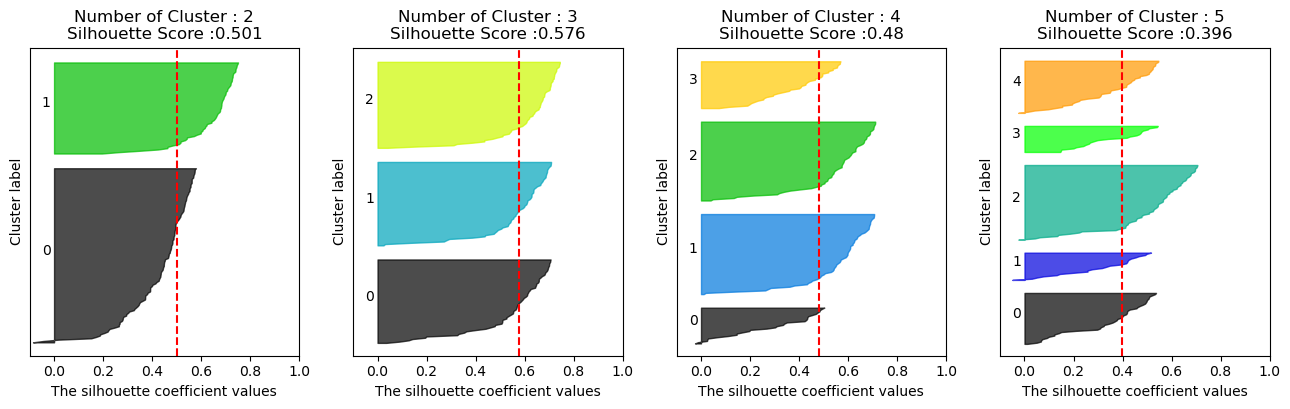

In [55]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")
        
cluster_lists = [2,3,4,5]
visualize_silhouette(cluster_lists, X)

# 2. 클러스팅을 위한 데이터 셋 생성

In [18]:
from sklearn.datasets import make_blobs

X,y = make_blobs(n_samples= 200, n_features=2, centers=3, cluster_std=0.8, random_state=0)
print(X.shape, y.shape)

#y target 값의 분포 확인
unique, counts = np.unique(y, return_counts = True)
print(unique, counts) #3개의 클러스터(0,1,2)로 이루어져 있으며 각각 67,67,66으로 균일하게 구성되어 있음 

(200, 2) (200,)
[0 1 2] [67 67 66]


In [17]:
cluster_df = pd.DataFrame(X,columns=['ftr1','ftr2'])
cluster_df['target'] = y
cluster_df.head()

,ftr1,ftr2,target
0,-1.692427,3.622025,2
1,0.697940,4.428867,0
2,1.100228,4.606317,0
3,-1.448724,3.384245,2
4,1.214861,5.364896,0


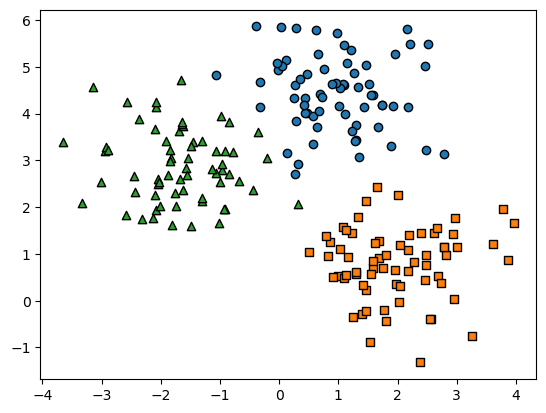

In [21]:
target_list = np.unique(y)
markers = ['o','s','^','P','D','H','x']
#3개의 군집 영역으로 구분한 데이터 셋을 생성했으므로 target_list는 [0,1,2]
#target =0, target=1, target=2로 scatter plot을 marker별로 생성
for target in target_list : 
    target_cluster = cluster_df[cluster_df['target']==target]
    plt.scatter(x=target_cluster['ftr1'], y=target_cluster['ftr2'],edgecolor='k',
                marker = markers[target])

plt.show()
    

In [31]:
KM = KMeans(n_clusters=3, init= 'k-means++', max_iter = 200, random_state= 0)
cluster_labels= KM.fit_predict(X) # X 데이터 군집화 
cluster_df['kmeans_label'] = cluster_labels

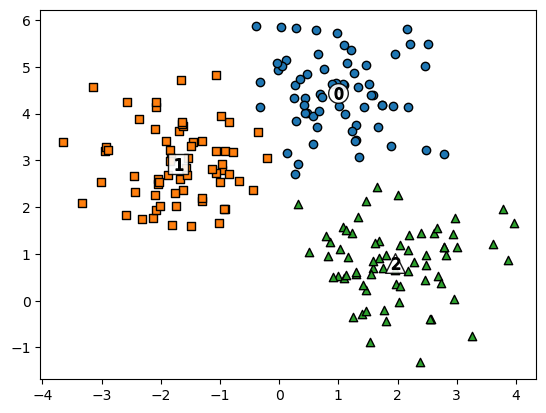

In [36]:
centers = KM.cluster_centers_
unique_labels = np.unique(cluster_labels)

markers = ['o','s','^','P','D','H','x']

#군집된 label 유형별로 iteration 하면서 marker별로 scatter plot 수행 
for label in unique_labels : 
    label_cluster = cluster_df[cluster_df['kmeans_label']==label]
    plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'],edgecolor='k',
                marker = markers[label])
    
    #군집별 중심 위치 좌표 시각화
    center_x_y = centers[label]
    plt.scatter(x=center_x_y[0], y = center_x_y[1], s=200, color = 'white',
                alpha = 0.9, edgecolor = 'k', marker = markers[label])
    plt.scatter(x=center_x_y[0], y = center_x_y[1], s=70, color = 'k',
                edgecolors='k', marker='$%d$' % label)

plt.show()


In [38]:
print(cluster_df.groupby('target')['kmeans_label'].value_counts())

target  kmeans_label
0       0               66
        1                1
1       2               67
2       1               65
        2                1
Name: kmeans_label, dtype: int64
